<a href="https://colab.research.google.com/github/vndee/aivivn-timeseries/blob/master/lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

In [0]:

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = F.max_pool2d(y, 2)
        y = F.relu(self.conv2(y))
        y = F.max_pool2d(y, 2)
        y = y.view(y.size(0), -1)
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        return self.fc3(y)


In [0]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
if not os.path.exists('./data'):
    os.makedirs('./data')

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=120, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_accuracy = 0
max_epoch = 100
learning_rate = 0.001


0it [00:00, ?it/s]

170500096it [00:09, 17244075.26it/s]                               


Files already downloaded and verified


In [5]:
"""###Build model"""

print('DEVICE', device)
model = LeNet().to(device)
if device is 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

DEVICE cuda
DataParallel(
  (module): LeNet(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [6]:


"""###Training"""

history_train = []
history_evaluation = []

def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    history_train.append([train_loss/total, 100.*correct/total])
    print(' -> train_loss: %.3f | train_acc: %.3f' % (train_loss/total, 100.*correct/total))
        
        
def evaluation(epoch):
    global best_accuracy
    model.eval()
    evaluation_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            evaluation_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    history_evaluation.append([evaluation_loss/total, 100.*correct/total])
    print(' -> eval_loss: %.3f | eval_acc: %.3f' % (evaluation_loss/total, 100.*correct/total))
    
    acc = 100.*correct/total
    if acc > best_accuracy:
        print('\t=> [SAVING] New best accuracy: %f' % acc)
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        
        if not os.path.exists('./checkpoint'):
            os.makedirs('./checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_accuracy = acc

for epoch in range(max_epoch):
    print('Epoch [%d/%d]:' % (epoch, max_epoch), end='')
    train(epoch)
    evaluation(epoch)





Epoch [0/100]: -> train_loss: 0.018 | train_acc: 10.000
 -> eval_loss: 0.019 | eval_acc: 10.000
	=> [SAVING] New best accuracy: 10.000000
Epoch [1/100]: -> train_loss: 0.018 | train_acc: 10.058
 -> eval_loss: 0.019 | eval_acc: 10.400
	=> [SAVING] New best accuracy: 10.400000
Epoch [2/100]: -> train_loss: 0.018 | train_acc: 12.224
 -> eval_loss: 0.019 | eval_acc: 10.560
	=> [SAVING] New best accuracy: 10.560000
Epoch [3/100]: -> train_loss: 0.018 | train_acc: 10.984
 -> eval_loss: 0.019 | eval_acc: 10.730
	=> [SAVING] New best accuracy: 10.730000
Epoch [4/100]: -> train_loss: 0.018 | train_acc: 11.040
 -> eval_loss: 0.019 | eval_acc: 11.600
	=> [SAVING] New best accuracy: 11.600000
Epoch [5/100]: -> train_loss: 0.017 | train_acc: 16.720
 -> eval_loss: 0.018 | eval_acc: 22.160
	=> [SAVING] New best accuracy: 22.160000
Epoch [6/100]: -> train_loss: 0.016 | train_acc: 24.086
 -> eval_loss: 0.017 | eval_acc: 26.450
	=> [SAVING] New best accuracy: 26.450000
Epoch [7/100]: -> train_loss: 0.01

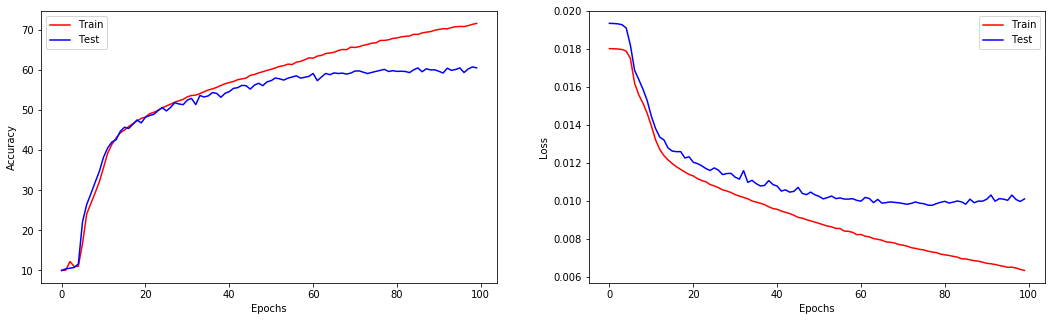

<Figure size 432x288 with 0 Axes>

In [7]:
train_loss = [x[0] for x in history_train]
train_acc = [x[1] for x in history_train]
eval_loss = [x[0] for x in history_evaluation]
eval_acc = [x[1] for x in history_evaluation]

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, 'r', label='Train')
plt.plot(eval_acc, 'b', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, 'r', label='Train')
plt.plot(eval_loss, 'b', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("result.png")